# Basic Imports

In [1]:
import gym
import torch
import matplotlib.pyplot as plt
import argparse
import operator
import numpy as np
import scipy.ndimage
from collections import deque
from typing import Dict, List, Tuple
import random
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from typing import Deque, Dict, List, Tuple
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_
import copy
import os
import math
import warnings
warnings.filterwarnings("ignore")


In [2]:
# https://github.com/openai/baselines/blob/master/baselines/common/segment_tree.py
class SegmentTree(object):
    def __init__(self, capacity, operation, neutral_element):
        """Build a Segment Tree data structure.
        https://en.wikipedia.org/wiki/Segment_tree
        Can be used as regular array, but with two
        important differences:
            a) setting item's value is slightly slower.
               It is O(lg capacity) instead of O(1).
            b) user has access to an efficient ( O(log segment size) )
               `reduce` operation which reduces `operation` over
               a contiguous subsequence of items in the array.
        Parameters
        ---------
        capacity: int
            Total size of the array - must be a power of two.
        operation: lambda obj, obj -> obj
            and operation for combining elements (eg. sum, max)
            must form a mathematical group together with the set of
            possible values for array elements (i.e. be associative)
        neutral_element: obj
            neutral element for the operation above. eg. float('-inf')
            for max and 0 for sum.
        """
        assert capacity > 0 and capacity & (capacity - 1) == 0, "capacity must be positive and a power of 2."
        self._capacity = capacity
        self._value = [neutral_element for _ in range(2 * capacity)]
        self._operation = operation

    def _reduce_helper(self, start, end, node, node_start, node_end):
        if start == node_start and end == node_end:
            return self._value[node]
        mid = (node_start + node_end) // 2
        if end <= mid:  # search left
            return self._reduce_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:  # search right
                return self._reduce_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self._operation(
                    self._reduce_helper(start, mid, 2 * node, node_start, mid),
                    self._reduce_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end)
                )

    def reduce(self, start=0, end=None):
        """Returns result of applying `self.operation`
        to a contiguous subsequence of the array.
            self.operation(arr[start], operation(arr[start+1], operation(... arr[end])))
        Parameters
        ----------
        start: int
            beginning of the subsequence
        end: int
            end of the subsequences
        Returns
        -------
        reduced: obj
            result of reducing self.operation over the specified range of array elements.
        """
        if end is None or end < 0 or end > self._capacity:
            end = self._capacity

        end -= 1
        return self._reduce_helper(start, end, 1, 0, self._capacity - 1)

    def __setitem__(self, idx, val):
        # index of the leaf
        idx += self._capacity
        self._value[idx] = val
        idx //= 2
        while idx >= 1:
            self._value[idx] = self._operation(
                self._value[2 * idx],
                self._value[2 * idx + 1]
            )
            idx //= 2

    def __getitem__(self, idx):
        assert 0 <= idx < self._capacity
        return self._value[self._capacity + idx]

    def __str__(self):
        return str(self._value[self._capacity:])


class SumSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(SumSegmentTree, self).__init__(
            capacity=capacity,
            operation=operator.add,
            neutral_element=0.0
        )

    def sum(self, start=0, end=None):
        """Returns arr[start] + ... + arr[end]"""
        return super(SumSegmentTree, self).reduce(start, end)

    def find_prefixsum_idx(self, prefixsum):
        """Find the highest index `i` in the array such that
            sum(arr[0] + arr[1] + ... + arr[i - i]) <= prefixsum
        if array values are probabilities, this function
        allows to sample indexes according to the discrete
        probability efficiently.
        Parameters
        ----------
        prefixsum: float
            upperbound on the sum of array prefix
        Returns
        -------
        idx: int
            highest index satisfying the prefixsum constraint
        """
        assert 0 <= prefixsum <= self.sum() + 1e-5
        idx = 1
        while idx < self._capacity:  # while non-leaf
            if self._value[2 * idx] > prefixsum:
                idx = 2 * idx
            else:
                prefixsum -= self._value[2 * idx]
                idx = 2 * idx + 1
        return idx - self._capacity


class MinSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(MinSegmentTree, self).__init__(
            capacity=capacity,
            operation=min,
            neutral_element=float('inf')
        )

    def min(self, start=0, end=None):
        """Returns min(arr[start], ...,  arr[end])"""

        return super(MinSegmentTree, self).reduce(start, end)

In [3]:
class FrameStack:
    """A container storing a limited amount of stacked observations,
    it is possible to add new frames and remove the oldest ones like a deque"""
    def __init__(self, dimension=1, mode="array"):
        self.frames = None  # [H, W, C] or [W]
        self.mode = mode  # 'array' or 'pixels'
        self.dimension = dimension  # how many frames to stack together
        self.curr_frames = 0
        self.w = None
        self.h = None
        self.c = None

    def unstack(self):
        """Unstack the oldest frame"""
        assert self.w is not None and self.curr_frames > 0
        if self.mode == "array":
            self.frames = self.frames[self.w:]
        if self.mode == "pixels":
            self.frames = self.frames[self.h:]
        self.curr_frames -= 1

    def stack(self, img, repeat=1):
        """Stack a frame (img) at the end repeated n times"""
        assert 0 <= repeat
        for _ in range(repeat):
            if self.mode == "array":
                if self.curr_frames == 0:
                    self.w = img.shape[0]
                    self.frames = img
                else:
                    self.frames = np.concatenate((self.frames, img), axis=-1)
            if self.mode == "pixels":
                if self.curr_frames == 0:
                    self.w = img.shape[1]
                    self.h = img.shape[0]
                    self.c = img.shape[2]
                    self.frames = img
                else:
                    self.frames = np.concatenate((self.frames, img), axis=0)
            self.curr_frames += 1
            if self.curr_frames > self.dimension:
                self.unstack()
        return self.frames

    def clear(self):
        """Remove all frames"""
        while self.curr_frames > 0:
            self.unstack()

    def full(self):
        """Return True if the stack is full"""
        return self.curr_frames == self.dimension

    def __len__(self):
        return self.curr_frames

    def get_frames(self):
        return self.frames

In [4]:
def grayscale(img):
    img = img.mean(axis=2)
    return img


def normalize(img):
    img = (img - 128) / 128 - 1
    return img


def resize(img, scale):
    img = scipy.ndimage.zoom(img, scale, order=1)
    return img


def crop(img, y, x, height, width):
    img = img[y:y+height, x:x+width]
    return img


mspacman_color = np.array([210, 164, 74]).mean()
def preprocess_obs_pacman(obs):
    img = obs[1:176:2, ::2]  # crop and downsize
    img = img.mean(axis=2)  # to greyscale
    img[img == mspacman_color] = 0  # improve contrast
    img = (img - 128) / 128 - 1  # normalize from -1. to 1.
    return img.reshape(88, 80, 1)  # reshape and return

#Rainbow

[M. Hessel et al., "Rainbow: Combining Improvements in Deep Reinforcement Learning." arXiv preprint arXiv:1710.02298, 2017.](https://arxiv.org/pdf/1710.02298.pdf)

We will integrate all the following seven components into a single integrated agent, which is called Rainbow!

1. DQN
2. Double DQN
3. Prioritized Experience Replay
4. Dueling Network
5. Noisy Network
6. Categorical DQN
7. N-step Learning

This method shows an impressive performance on the Atari 2600 benchmark, both in terms of data efficiency and final performance.

![rainbow](https://user-images.githubusercontent.com/14961526/60591412-61748100-9dd9-11e9-84fb-076c7a61fbab.png)

However, the integration is not so simple because some of components are not independent each other, so we will look into a number of points that people especailly feel confused.

1. Noisy Network <-> Dueling Network
2. Dueling Network <-> Categorical DQN
3. Categorical DQN <-> Double DQN

## Replay Buffer Implementations

### `ReplayBuffer`

The `ReplayBuffer` class is a basic implementation of an experience replay buffer, which is essential for training reinforcement learning (RL) algorithms. It stores the experiences of an agent, including observations, actions, rewards, next observations, and done flags. These experiences are crucial for the agent's learning process.

#### Key Features

- **Numpy Implementation**: Utilizes Numpy arrays to efficiently manage and store experiences.
- **N-step Learning Support**: Incorporates logic for N-step learning, which considers rewards from multiple future steps when updating the agent's knowledge.
- **Experience Sampling**: Supports random sampling of experiences from the buffer, facilitating diverse training samples for the RL agent.

#### Operations

- **Initialization**: Configures the buffer with specified dimensions for observations, size of the buffer, batch size for sampling, N-step count, and the discount factor (gamma).
- **Storing Experiences**: Handles storing single experiences and managing N-step transitions, accommodating the accumulation of rewards and adjustment of observations and done flags.
- **Batch Sampling**: Allows for the random sampling of a batch of experiences, critical for training the RL model with a variety of experiences.

### `PrioritizedReplayBuffer`

Extending `ReplayBuffer`, the `PrioritizedReplayBuffer` introduces priority-based sampling of experiences, enhancing the learning efficiency by focusing more on significant experiences.

#### Enhancements

- **Priority-Based Sampling**: Implements mechanisms to assign and update priorities to experiences, with the sampling process biased towards experiences with higher priorities.
- **Efficient Priority Management**: Utilizes a sum segment tree and a min segment tree for managing priorities and efficiently sampling experiences according to their importance.
- **Importance Sampling Weights**: Calculates weights for the sampled experiences to correct the bias introduced by prioritized sampling, using a beta parameter for bias correction.

#### Priority Handling

- **Initialization**: In addition to the base initialization, it configures alpha for adjusting the priority level of experiences.
- **Priority Updates**: Supports updating the priorities of experiences based on their temporal-difference (TD) errors, enhancing the focus on more informative experiences.
- **Weighted Experience Sampling**: Facilitates sampling based on experience priority, along with calculating and applying importance sampling weights to adjust for sampling bias.

These buffer implementations are integral for the efficient training of RL agents, with the prioritized replay buffer offering a sophisticated approach to focus training on more critical experiences.


In [5]:
class ReplayBuffer:
    """A simple numpy replay buffer.
    Parameters
    ---------
    obs_dim: list[int]
        Observation shape
    size: int
        # maximum number of elements in buffer
    batch_size: int
        batch_size
    n_step: int
        number of step used for N-step learning
    gamma: float
        gamma value
    """

    def __init__(
            self,
            obs_dim: List[int],
            size: int = 1024,
            batch_size: int = 32,
            n_step: int = 1,
            gamma: float = 0.99
    ):
        self.obs_buf = np.zeros([size, *obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, *obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

        # for N-step Learning
        self.n_step_buffer = deque(maxlen=n_step)
        self.n_step = n_step
        self.gamma = gamma

    def store(
            self,
            obs: np.ndarray,
            act: int,
            rew: float,
            next_obs: np.ndarray,
            done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool] or None:
        """Store a new experience in the buffer"""
        transition = (obs, act, rew, next_obs, done)
        self.n_step_buffer.append(transition)

        # single step transition is not ready
        if len(self.n_step_buffer) < self.n_step:
            return

        # make a n-step transition
        # take the n-reward, n-observation and n-done
        rew, next_obs, done = self._get_n_step()
        # take the 1-observation and 1-action
        obs, act = self._get_first_step()

        # store the transition
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

        return transition

    def sample_batch(self) -> Dict[str, np.ndarray]:
        """Sample a batch from the buffer"""
        assert len(self) >= self.batch_size
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
            # for N-step Learning
            indices=idxs,  # # need this for priority updating
        )

    def sample_batch_from_idxs(self, idxs: np.ndarray) -> Dict[str, np.ndarray]:
        """Sample a batch given some fixed idxs"""
        # for N-step Learning
        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )

    def _get_n_step(self) -> Tuple[np.int64, np.ndarray, bool]:
        """Return n step rew, next_obs, and done."""
        # info of the last transition
        rew, next_obs, done = self.n_step_buffer[-1][-3:]

        for transition in reversed(list(self.n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:]
            # update the reward
            rew = r + self.gamma * rew * (1 - d)
            # if done == 1: next_obs is the first observation where done == 1
            # if done == 0: next_obs is the n-observation
            next_obs, done = (n_o, d) if d else (next_obs, done)

        return rew, next_obs, done

    def _get_first_step(self) -> Tuple[np.int64, np.ndarray]:
        """Return first step obs and act."""
        # info of the first transition
        obs, act = self.n_step_buffer[0][:2]

        return obs, act

    def __len__(self) -> int:
        return self.size


class PrioritizedReplayBuffer(ReplayBuffer):
    """Prioritized Replay buffer.
    Attributes:
        max_priority: float
            max priority
        tree_ptr: int
            next index of tree
        alpha: float
            alpha parameter for prioritized replay buffer
        sum_tree: SumSegmentTree
            sum tree for prior
        min_tree: MinSegmentTree
            min tree for min prior to get max weight
    """

    def __init__(
            self,
            obs_dim: List[int],
            size: int = 1024,
            batch_size: int = 32,
            alpha: float = 0.6,
            n_step: int = 1,
            gamma: float = 0.99,
    ):
        """Initialization."""
        assert alpha >= 0

        super(PrioritizedReplayBuffer, self).__init__(
            obs_dim, size, batch_size, n_step, gamma
        )
        self.max_priority = 1.0
        self.tree_ptr = 0
        self.alpha = alpha

        # capacity must be positive and a power of 2.
        tree_capacity = 1
        while tree_capacity < self.max_size:
            tree_capacity *= 2

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)

    def store(
            self,
            obs: np.ndarray,
            act: int,
            rew: float,
            next_obs: np.ndarray,
            done: bool,
    ) -> Tuple[np.ndarray, int, float, np.ndarray, bool]:
        """Store an experience and its priority."""
        transition = super().store(obs, act, rew, next_obs, done)

        if transition:
            self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.tree_ptr = (self.tree_ptr + 1) % self.max_size

        return transition

    def sample_batch(self, beta: float = 0.4) -> Dict[str, np.ndarray]:
        """Sample a batch of experiences."""
        assert len(self) >= self.batch_size
        assert beta > 0

        # samples transitions indices
        indices = self._sample_proportional()

        obs = self.obs_buf[indices]
        next_obs = self.next_obs_buf[indices]
        acts = self.acts_buf[indices]
        rews = self.rews_buf[indices]
        done = self.done_buf[indices]
        # importance sampling weights
        weights = np.array([self._calculate_weight(i, beta) for i in indices])

        return dict(
            obs=obs,
            next_obs=next_obs,
            acts=acts,
            rews=rews,
            done=done,
            weights=weights,
            indices=indices,  # need this for priority updating
        )

    def update_priorities(self, indices: List[int], priorities: np.ndarray):
        """Update priorities of sampled transitions."""
        assert len(indices) == len(priorities)

        for idx, priority in zip(indices, priorities):
            assert priority > 0
            assert 0 <= idx < len(self)

            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha

            self.max_priority = max(self.max_priority, priority)

    def _sample_proportional(self) -> List[int]:
        """Sample indices based on proportions."""
        indices = []
        p_total = self.sum_tree.sum(0, len(self))
        segment = p_total / self.batch_size

        # perform a random sample in each segment
        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            upper_bound = random.uniform(a, b)
            idx = self.sum_tree.find_prefixsum_idx(upper_bound)
            indices.append(idx)

        return indices

    def _calculate_weight(self, idx: int, beta: float):
        """Calculate the weight of the experience at idx."""
        # get max weight
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * len(self)) ** (-beta)

        # calculate weights
        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * len(self)) ** (-beta)
        weight = weight / max_weight

        return weight

## NoisyNet + DuelingNet

### `NoisyLinear`

A custom PyTorch module designed for NoisyNets, adding noise to the parameters of a linear layer to encourage exploration directly through the network's weights.

#### Attributes
- **in_features**: Size of each input sample.
- **out_features**: Size of each output sample.
- **std_init**: Initial standard deviation for the noise.
- **weight_mu**: Mean of the weights.
- **weight_sigma**: Standard deviation of the weights.
- **bias_mu**: Mean of the biases.
- **bias_sigma**: Standard deviation of the biases.

#### Operations
- **reset_parameters()**: Initializes parameters with noise.
- **reset_noise()**: Generates new noise for weights and biases.
- **forward(x)**: Applies the noisy linear transformation to the input `x`.
- **scale_noise(size)**: Generates factorized Gaussian noise.

### `DenseNet`

A dense neural network module, optionally utilizing `NoisyLinear` for exploration and dueling architecture for estimating state value and advantage separately.

#### Attributes
- **support**: Tensor defining the support of the Q distribution.
- **hidden_size**: Size of hidden layers.
- **no_dueling**: Whether to disable dueling architecture.
- **no_noise**: Whether to use standard linear layers instead of `NoisyLinear`.

#### Operations
- **forward(x)**: Estimates Q values from input states.
- **dist(x)**: Computes the distribution over Q values.
- **reset_noise()**: Resets noise in all `NoisyLinear` layers.

### `ConvNet`

A convolutional neural network module for processing visual inputs, with optional `NoisyLinear` layers and dueling architecture.

#### Attributes
- Inherits attributes from `DenseNet` for dueling and noise options.
- Adds convolutional layers (`conv1`, `conv2`, `conv3`) for visual input processing.

#### Operations
- Similar to `DenseNet` but preprocesses inputs through convolutional layers before dense processing.


In [6]:
class NoisyLinear(nn.Module):
    """Noisy linear module for NoisyNet.

    Attributes:
        in_features (int): input size of linear module
        out_features (int): output size of linear module
        std_init (float): initial std value
        weight_mu (nn.Parameter): mean value weight parameter
        weight_sigma (nn.Parameter): std value weight parameter
        bias_mu (nn.Parameter): mean value bias parameter
        bias_sigma (nn.Parameter): std value bias parameter
    """

    def __init__(
            self,
            in_features: int,
            out_features: int,
            std_init: float = 0.5,
    ):
        """Initialization."""
        super(NoisyLinear, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init  # used to initialize weight_sigma and bias_sigma

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(
            torch.Tensor(out_features, in_features)
        )

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))

        self.register_buffer(
            "weight_epsilon", torch.Tensor(out_features, in_features)
        )
        self.register_buffer("bias_epsilon", torch.Tensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        """Reset trainable network parameters (factorized gaussian noise)."""
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(
            self.std_init / math.sqrt(self.in_features)
        )
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(
            self.std_init / math.sqrt(self.out_features)
        )

    def reset_noise(self):
        """Generate new noise and make epsilon matrices."""
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)

        # outer product
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Add noise to the parameters to perform the forward step"""
        return F.linear(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon,
        )

    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
        """Generate noise (factorized gaussian noise)."""
        x = torch.FloatTensor(np.random.normal(loc=0.0, scale=1.0, size=size))
        return x.sign().mul(x.abs().sqrt())


class DenseNet(nn.Module):
    """
    Attributes:
        in_dim (int): input size
        out_dim (int): output size
        atom_size (int): atom size, used to compute categorical distribution
        support (torch.Tensor): discrete support z
        hidden_size (int): hidden size
    """
    def __init__(
            self,
            in_dim: int,
            out_dim: int,
            atom_size: int,
            support: torch.Tensor,
            hidden_size: int,
            # options
            no_dueling=False,
            no_noise=False
    ):
        """Initialization."""
        super(DenseNet, self).__init__()

        self.support = support
        self.out_dim = out_dim
        self.atom_size = atom_size
        self.hidden_size = hidden_size

        # set common feature layer
        self.feature_layer = nn.Sequential(
            nn.Linear(in_dim, self.hidden_size),
            nn.ReLU(),
        )

        # set advantage layer
        self.advantage_hidden_layer = NoisyLinear(self.hidden_size, self.hidden_size)
        self.advantage_layer = NoisyLinear(self.hidden_size, out_dim * atom_size)  # output one distribution per action
        # set value layer
        self.value_hidden_layer = NoisyLinear(self.hidden_size, self.hidden_size)
        self.value_layer = NoisyLinear(self.hidden_size, atom_size)

        # options
        self.no_dueling = no_dueling
        self.no_noise = no_noise
        if no_noise:
            # use linear standard layers
            self.advantage_hidden_layer = nn.Linear(self.hidden_size, self.hidden_size)
            self.advantage_layer = nn.Linear(self.hidden_size, out_dim * atom_size)
            self.value_hidden_layer = nn.Linear(self.hidden_size, self.hidden_size)
            self.value_layer = nn.Linear(self.hidden_size, atom_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation, return one Q-value for each action."""
        dist = self.dist(x)
        q = torch.sum(dist * self.support, dim=2)
        return q

    def dist(self, x: torch.Tensor) -> torch.Tensor:
        """Get distribution for atoms, one distribution for each action."""
        feature = self.feature_layer(x)
        adv_hid = F.relu(self.advantage_hidden_layer(feature))
        val_hid = F.relu(self.value_hidden_layer(feature))

        advantage = self.advantage_layer(adv_hid).view(
            -1, self.out_dim, self.atom_size
        )
        if not self.no_dueling:
            value = self.value_layer(val_hid).view(-1, 1, self.atom_size)
            q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)
        else:
            # disable dueling network, ignore value layer and advantage formula
            q_atoms = advantage

        dist = F.softmax(q_atoms, dim=-1)
        dist = dist.clamp(min=1e-3)  # for avoiding nans

        return dist

    def reset_noise(self):
        """Reset all noisy layers."""
        self.advantage_hidden_layer.reset_noise()
        self.advantage_layer.reset_noise()
        self.value_hidden_layer.reset_noise()
        self.value_layer.reset_noise()


class ConvNet(nn.Module):
    """
    Attributes:
        in_dim (int): input size
        out_dim (int): output size
        atom_size (int): atom size, used to compute categorical distribution
        support (torch.Tensor): discrete support z
    """
    def __init__(
            self,
            in_dim: List[int],  # (h, w, c)
            out_dim: int,
            atom_size: int,
            support: torch.Tensor,
            # options
            no_dueling=False,
            no_noise=False
    ):
        """Initialization."""
        super(ConvNet, self).__init__()

        self.support = support
        self.out_dim = out_dim
        self.atom_size = atom_size

        # conv layer (input at least 1 x 1 x 40 x 40)
        self.conv1 = nn.Conv2d(in_dim[2], 16, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size=8, stride=4):
            return (size - (kernel_size - 1) - 1) // stride + 1

        conv_w = conv2d_size_out(conv2d_size_out(conv2d_size_out(in_dim[1], 8, 4), 4, 2), 3, 1)
        conv_h = conv2d_size_out(conv2d_size_out(conv2d_size_out(in_dim[0], 8, 4), 4, 2), 3, 1)
        self.hidden_size = conv_w * conv_h * 32

        # set advantage layer
        self.advantage_hidden_layer = NoisyLinear(self.hidden_size, self.hidden_size)
        self.advantage_layer = NoisyLinear(self.hidden_size, out_dim * atom_size)  # output one distribution per action
        # set value layer
        self.value_hidden_layer = NoisyLinear(self.hidden_size, self.hidden_size)
        self.value_layer = NoisyLinear(self.hidden_size, atom_size)

        # options
        self.no_dueling = no_dueling
        self.no_noise = no_noise
        if no_noise:
            # use linear standard layers
            self.advantage_hidden_layer = nn.Linear(self.hidden_size, self.hidden_size)
            self.advantage_layer = nn.Linear(self.hidden_size, out_dim * atom_size)
            self.value_hidden_layer = nn.Linear(self.hidden_size, self.hidden_size)
            self.value_layer = nn.Linear(self.hidden_size, atom_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation, return one Q-value for each action."""
        dist = self.dist(x)
        q = torch.sum(dist * self.support, dim=2)
        return q

    def dist(self, x: torch.Tensor) -> torch.Tensor:
        """Get distribution for atoms, one distribution for each action."""
        x = x.permute(0, 3, 1, 2)  # adapt to pytorch format
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        feature = x.reshape(x.shape[0], -1)

        adv_hid = F.relu(self.advantage_hidden_layer(feature))
        val_hid = F.relu(self.value_hidden_layer(feature))

        advantage = self.advantage_layer(adv_hid).view(
            -1, self.out_dim, self.atom_size
        )
        if not self.no_dueling:
            value = self.value_layer(val_hid).view(-1, 1, self.atom_size)
            q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)
        else:
            # disable dueling network, ignore value layer and advantage formula
            q_atoms = advantage

        dist = F.softmax(q_atoms, dim=-1)
        dist = dist.clamp(min=1e-3)  # for avoiding nans

        return dist

    def reset_noise(self):
        """Reset all noisy layers."""
        self.advantage_hidden_layer.reset_noise()
        self.advantage_layer.reset_noise()
        self.value_hidden_layer.reset_noise()
        self.value_layer.reset_noise()

## Rainbow Agent

## Rainbow Agent Implementation

This section outlines the implementation of a comprehensive DQNAgent class, encapsulating various enhancements to the traditional DQN algorithm, collectively known as the Rainbow DQN. The class integrates several key techniques such as Dueling Networks, Noisy Networks, Categorical DQN (for distributional value estimation), N-step learning, and Prioritized Experience Replay (PER), providing a robust framework for reinforcement learning tasks.

### Core Methods and Attributes

- **select_action**: Selects an action based on the current state, employing an ε-greedy strategy or leveraging Noisy Networks for exploration.
- **step**: Executes the chosen action in the environment, returning the next state, reward, and done flag. It also handles frame stacking and reward clipping.
- **compute_dqn_loss**: Calculates the loss for a batch of experiences, which could be the standard DQN loss or a distributional loss in the case of Categorical DQN.
- **update_model**: Updates the neural network model using the computed loss and applies gradient clipping.
- **target_hard_update**: Periodically synchronizes the weights of the target network with those of the online network.
- **train**: Manages the training loop, including action selection, model updating, and logging.
- **test**: Evaluates the agent's performance in the environment without learning.
- **_plot**: Visualizes the training progress in terms of scores and losses.

### Advanced Techniques Integration

- **Categorical DQN + Double DQN**: Combines the distributional approach to Q-value estimation with Double DQN's strategy for reducing overestimations in value assessment.
- **Prioritized Experience Replay**: Enhances sample efficiency by prioritizing transitions based on their temporal difference error, adjusted dynamically.
- **N-Step Learning**: Extends the temporal difference calculation over multiple steps for a more far-sighted update.
- **Noisy Networks**: Introduces parameter noise for exploration, automatically adjusting the exploration-exploitation balance.
- **Dueling Network Architecture**: Decomposes Q-value estimation into state value and action advantage components for more precise value assessment.

### Configuration and Options

The agent's constructor accepts numerous parameters allowing for extensive customization of the learning process, including the size of the replay buffer, batch size, learning rate, and the configuration of advanced features like Dueling Networks, Noisy Networks, and Categorical DQN. It provides toggles to enable or disable specific enhancements according to the task's requirements.

### Usage and Flexibility

This implementation offers a versatile framework for experimenting with different combinations of enhancements to the DQN algorithm. It is designed to be adaptable to various environments, input preprocessing needs, and reinforcement learning challenges, making it a powerful tool for both research and practical applications.


In [ ]:
class DQNAgent:
    """DQN Agent interacting with environment.

    Attribute:
        env (gym.Env): openAI Gym environment
        memory (PrioritizedReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including
                           state, action, reward, next_state, done
        v_min (float): min value of support
        v_max (float): max value of support
        atom_size (int): the unit number of support
        support (torch.Tensor): support for categorical dqn
        n_step (int): step number to calculate n-step td error
        hidden_size (int): size of the layers of the top dense network
        lr (float): learning rate
        plot (bool): if True, plot training charts
        frame_interval (int): steps per plotting refresh
        alpha (float): determines how much prioritization is used
        beta (float): determines how much importance sampling is used
        prior_eps (float): guarantees every transition can be sampled
        max_epsilon (float): starting epsilon value
        min_epsilon (float): finish epsilon value
        epsilon_decay (float): epsilon decay for each step
    """

    def __init__(
            self,
            env: gym.Env,
            memory_size: int = 1024,
            batch_size: int = 32,
            target_update: int = 100,
            gamma: float = 0.99,
            lr: float =0.001,
            hidden_size=128,
            # PER parameters
            alpha: float = 0.2,
            beta: float = 0.6,
            prior_eps: float = 1e-6,
            # Categorical DQN parameters
            v_min: float = 0.0,
            v_max: float = 200.0,
            atom_size: int = 51,
            # N-step Learning
            n_step: int = 3,
            # Plotting
            plot: bool = True,
            frame_interval: int = 100,
            # Options
            no_dueling: bool = False,
            no_double: bool = False,
            no_noise: bool = False,
            no_categorical: bool = False,
            no_priority: bool = False,
            no_n_step: bool = False,
            # Only if no_noise is True
            max_epsilon: float = 1.,
            min_epsilon: float = 0.1,
            epsilon_decay: float = 0.0005,
            # Reward clipping
            max_reward: float = None,
            min_reward: float = None,
            # Input preprocessing functions
            frame_preprocess: np.array = None,  # this is a function
            # Early stopping
            early_stopping: bool = True,
            # Frames_stacking
            n_frames_stack: int = 1,
            # training delay
            training_delay: int = 0,  # how many frames to skip before start training (used to fill the memory buffer)
            # used for saving and loading
            model_path: str = "models",
            model_name: str = "rainbow"
    ):
        obs_shape = env.observation_space.shape  # get shape of an observation
        if frame_preprocess is not None:
            obs_shape = frame_preprocess(np.zeros(obs_shape)).shape  # get shape of preprocessed observation
        if n_frames_stack > 1:  # if the input consists of more than 1 frame, compute its total dimension
            obs_shape = list(obs_shape)
            obs_shape[0] *= n_frames_stack
        assert len(obs_shape) == 3 or len(obs_shape) == 1
        if len(obs_shape) == 1:  # observation is an array
            print("Using DenseNet")
            self.obs_dim = [obs_shape[0]]
            self.mode = "dense"
            self.frame_stack = FrameStack(n_frames_stack, mode="array")
        else:
            print("Using ConvNet")  # observation is a frame
            # remember: gym has dimension (w, h, c) but pytorch has (c, h, w)
            self.obs_dim = [obs_shape[0], obs_shape[1], obs_shape[2]]
            self.mode = "conv"
            self.frame_stack = FrameStack(n_frames_stack, mode="pixels")

        #self.action_dim = env.action_space.n  # get number of possible actions
        if isinstance(env.action_space, gym.spaces.Discrete):
          self.action_dim = env.action_space.n
        elif isinstance(env.action_space, gym.spaces.Box):
          self.action_dim = env.action_space.shape[0]  # For continuous action space, consider the shape


        self.n_frames_stack = n_frames_stack  # number of stacked input observations

        self.env = env  # the the gym environment
        self.batch_size = batch_size
        self.target_update = target_update
        self.gamma = gamma
        self.hidden_size = hidden_size  # this parameters is used only with DenseNet

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print("Device", self.device)

        # PER and memory for N-step Learning (PER = Prioritized Experience Replay)
        self.beta = beta
        self.prior_eps = prior_eps
        self.memory = PrioritizedReplayBuffer(
            self.obs_dim, memory_size, batch_size, alpha=alpha, n_step=n_step, gamma=gamma
        )
        self.n_step = n_step

        # Categorical DQN parameters
        self.v_min = v_min
        self.v_max = v_max
        self.atom_size = atom_size
        self.support = torch.linspace(
            self.v_min, self.v_max, self.atom_size
        ).to(self.device)

        # networks: dqn, dqn_target
        if self.mode == "dense":
            # if input is 1d array use dense layers
            self.dqn = DenseNet(
                self.obs_dim[0], self.action_dim, self.atom_size, self.support, self.hidden_size, no_dueling, no_noise
            ).to(self.device)
            self.dqn_target = DenseNet(
                self.obs_dim[0], self.action_dim, self.atom_size, self.support, self.hidden_size, no_dueling, no_noise
            ).to(self.device)
        else:
            # if input is 3d frame use convolutional layers
            self.dqn = ConvNet(
                self.obs_dim, self.action_dim, self.atom_size, self.support, no_dueling, no_noise
            ).to(self.device)
            self.dqn_target = ConvNet(
                self.obs_dim, self.action_dim, self.atom_size, self.support, no_dueling, no_noise
            ).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())  # DQN <- targetDQN
        self.dqn_target.eval()

        # early stropping
        self.early_stopping = early_stopping

        # optimizer
        self.lr = lr
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=self.lr)

        # current transition to store in memory
        self.transition = list()

        # training delay
        self.training_delay = training_delay

        # mode: train / test
        self.is_test = False

        # reward clipping
        self.max_reward = max_reward
        self.min_reward = min_reward

        # save / load
        self.model_dir = model_path
        self.model_path = os.path.join(model_path, model_name + ".tar")

        # observation preprocess function (convert to grayscale, crop, resize...)
        self.frame_preprocess = frame_preprocess

        # plot
        self.plot = plot
        self.frame_interval = frame_interval

        # epsilon (used only if noisy net is disabled)
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.epsilon = self.max_epsilon
        self.epsilon_decay = epsilon_decay

        # options to disable some features
        self.no_dueling = no_dueling  # no dueling
        self.no_double = no_double  # no double
        if no_double:
            self.dqn_target = self.dqn
        self.no_noise = no_noise  # no noise
        if no_noise:
            self.epsilon, self.max_epsilon, self.min_epsilon = 0, 0, 0
        self.no_categorical = no_categorical  # no categorical
        self.no_n_step = no_n_step  # no n_step
        if no_n_step:
            self.n_step = 1
            self.memory = PrioritizedReplayBuffer(
                self.obs_dim, memory_size, batch_size, alpha=alpha, n_step=self.n_step, gamma=gamma
            )
        self.no_priority = no_priority  # no priority memory
        if no_priority:
            self.alpha = 0
            self.memory = PrioritizedReplayBuffer(
                self.obs_dim, memory_size, batch_size, alpha=alpha, n_step=self.n_step, gamma=gamma
            )

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state and return state and action."""
        # epsilon greedy policy
        if self.no_noise and self.epsilon > np.random.random():
            # Select a random action
            selected_action = self.env.action_space.sample()
        else:
            # Select best action: no epsilon greedy action selection but NoisyNet
            selected_action = self.dqn(
                torch.FloatTensor(state).unsqueeze(0).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()

        if not self.is_test:
            self.transition = [state, selected_action]

        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env (next state, rewards, done)."""
        if isinstance(self.env.action_space, gym.spaces.Discrete):
          next_state, reward, done,_= self.env.step(action)
        else :
          next_state, reward, done,_= self.env.step(np.array([action.item()]))
        if self.frame_preprocess is not None:
            next_state = self.frame_preprocess(next_state)
        if self.n_frames_stack > 1:
            next_state = self.get_n_frames(next_state)

        if self.max_reward is not None:
            if reward > self.max_reward:
                reward = self.max_reward

        if self.min_reward is not None:
            if reward < self.min_reward:
                reward = self.min_reward

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)  # store a full transition

        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        # sample transitions
        samples = self.memory.sample_batch(self.beta)
        # PER needs beta to calculate weights
        weights = torch.FloatTensor(samples["weights"].reshape(-1, 1)).to(self.device)
        indices = samples["indices"]

        # N-step Learning loss
        gamma = self.gamma ** self.n_step
        elementwise_loss = self._compute_dqn_loss(samples, gamma)

        # PER: importance sampling before average
        loss = torch.mean(elementwise_loss * weights)

        self.optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(self.dqn.parameters(), 10.0)
        self.optimizer.step()

        # PER: update priorities
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        self.memory.update_priorities(indices, new_priorities)

        # NoisyNet: reset noise
        if not self.no_noise:
            self.dqn.reset_noise()
            self.dqn_target.reset_noise()

        return loss.item()

    def train(self, num_frames: int) -> (List[int], List[int]):
        """Train the agent."""
        self.is_test = False

        state = self.env.reset()
        # get the first state
        state = self.init_first_frame(state)

        update_cnt = 0  # counts the number of steps between each update
        losses = []  # loss for each training step
        scores = []  # score for each episode
        frame_scores = []  # average score each frame_interval frames
        score = 0  # current score
        if self.early_stopping:
            best_model = copy.deepcopy(self.dqn.state_dict())
            best_average_score = -np.inf

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            self.update_beta()

            # if episode ends
            if done:
                scores.append(score)
                state = self.env.reset()
                state = self.init_first_frame(state)
                score = 0

            # linearly decrease epsilon
            if self.no_noise:
                self.set_epsilon()

            # if training is ready
            if len(self.memory) >= self.batch_size and self.training_delay <= 0:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                # if hard update is needed
                if update_cnt % self.target_update == 0 and not self.no_double:
                    self._target_hard_update()

            if frame_idx % self.frame_interval == 0:
                if len(scores) == 0:
                    if len(frame_scores) > 0:
                        # if no episodes have been completed in the current interval
                        # then take the last score
                        frame_scores.append(float(frame_scores[-1]))
                    else:
                        # if no episodes have been completed since the beginning of the game
                        frame_scores.append(0.)
                else:
                    frame_scores.append(float(np.mean(scores)))
                if self.plot:
                    self._plot(frame_idx, frame_scores, losses)
                scores = []
                # early stopping
                if self.early_stopping and frame_scores[-1] > best_average_score:
                    best_average_score = frame_scores[-1]
                    best_model = copy.deepcopy(self.dqn.state_dict())
                # save temporary model
                self.save()

            if self.training_delay > 0:
                self.training_delay -= 1

        if self.early_stopping:
            self.dqn.load_state_dict(best_model)
        self.env.close()

        return frame_scores, losses

    def test(self, get_frames=False, get_actions=False) -> (int, List[int]) or (int, List[np.ndarray]):
        """Test the agent on one episode."""
        self.is_test = True

        state = self.env.reset()
        state = self.init_first_frame(state)

        done = False
        score = 0

        actions = []
        frames = []

        while not done:
            self.env.render()
            action = self.select_action(state)
            if get_actions:
                actions.append(action)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            if get_frames:
                frames.append(self.env.render(mode='rgb_array'))

        self.env.close()

        if get_frames and not get_actions:
            return score, frames
        if not get_frames and get_actions:
            return score, actions
        if get_frames and get_actions:
            return score, frames, actions

        return score

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray], gamma: float) -> torch.Tensor:
        """Return the loss."""
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"]).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        if not self.no_categorical:
            # # Compute categorical distribution loss
            delta_z = float(self.v_max - self.v_min) / (self.atom_size - 1)

            with torch.no_grad():
                next_action = self.dqn(next_state).argmax(1)
                next_dist = self.dqn_target.dist(next_state)
                next_dist = next_dist[range(self.batch_size), next_action]

                t_z = reward + (1 - done) * gamma * self.support
                t_z = t_z.clamp(min=self.v_min, max=self.v_max)
                b = (t_z - self.v_min) / delta_z
                l = b.floor().long()
                u = b.ceil().long()

                offset = (
                    torch.linspace(
                        0, (self.batch_size - 1) * self.atom_size, self.batch_size
                    ).long().unsqueeze(1).expand(self.batch_size, self.atom_size).to(self.device)
                )

                proj_dist = torch.zeros(next_dist.size(), device=self.device)
                proj_dist.view(-1).index_add_(
                    0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1)
                )
                proj_dist.view(-1).index_add_(
                    0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1)
                )

            dist = self.dqn.dist(state)
            log_p = torch.log(dist[range(self.batch_size), action])
            loss = -(proj_dist * log_p).sum(1)

        else:
            # Compute normal value estimation loss
            # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
            #       = r                       otherwise
            action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
            curr_q_value = self.dqn(state).gather(1, action)
            next_q_value = self.dqn_target(next_state).gather(
                1, self.dqn(next_state).argmax(dim=1, keepdim=True)
            )[0].detach()
            mask = 1 - done
            target = (reward + self.gamma * next_q_value * mask).to(self.device)

            # calculate dqn loss
            loss = F.smooth_l1_loss(curr_q_value, target, reduction="none")

        return loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def init_first_frame(self, state):
        """Preprocess the first frame and fill the empty frame stack repeating it"""
        if self.frame_preprocess is not None:
            state = self.frame_preprocess(state)
        if self.n_frames_stack > 1:
            self.frame_stack.clear()
            state = self.get_n_frames(state)
        return state

    def set_epsilon(self):
        """Set the value of epsilon"""
        self.epsilon = max(
            self.min_epsilon, self.epsilon - (
                    self.max_epsilon - self.min_epsilon
            ) * self.epsilon_decay
        )

    def update_beta(self):
        """Update beta parameter for PER"""
        self.epsilon = max(
            self.min_epsilon, self.epsilon - (
                    self.max_epsilon - self.min_epsilon
            ) * self.epsilon_decay
        )

    def get_n_frames(self, frame: np.ndarray) -> np.ndarray:
        """Return the last n frames"""
        if self.frame_stack.full():
            self.frame_stack.stack(frame, 1)
            return self.frame_stack.frames
        else:
            self.frame_stack.stack(frame, self.n_frames_stack)
            return self.frame_stack.frames

    def save(self):
        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)
        print("Saving model...")
        torch.save({
            'model': self.dqn.state_dict(),
        }, os.path.join(self.model_path))
        print("Model saved in: " + str(self.model_path))

    def load(self):
        print("Restoring saved model...")
        checkpoint = torch.load(self.model_path)
        self.dqn.load_state_dict(checkpoint['model'])
        print("Model restored from: " + str(self.model_path))

    def _plot(self, frame_idx: int, scores: List[float], losses: List[float]):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('Frame %s. Mean Score: %.4s' % (frame_idx,
                                                  np.mean(scores[-10:])))
        plt.plot(scores)
        plt.xlabel("Frames x " + str(self.frame_interval))
        plt.ylabel("Score")
        plt.subplot(132)
        plt.title('Loss')
        plt.plot(losses)
        plt.xlabel("Frames")
        plt.ylabel("Loss")
        plt.show()

In [ ]:
def set_seed(seed, env):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    random.seed(seed)
    env.seed(seed)

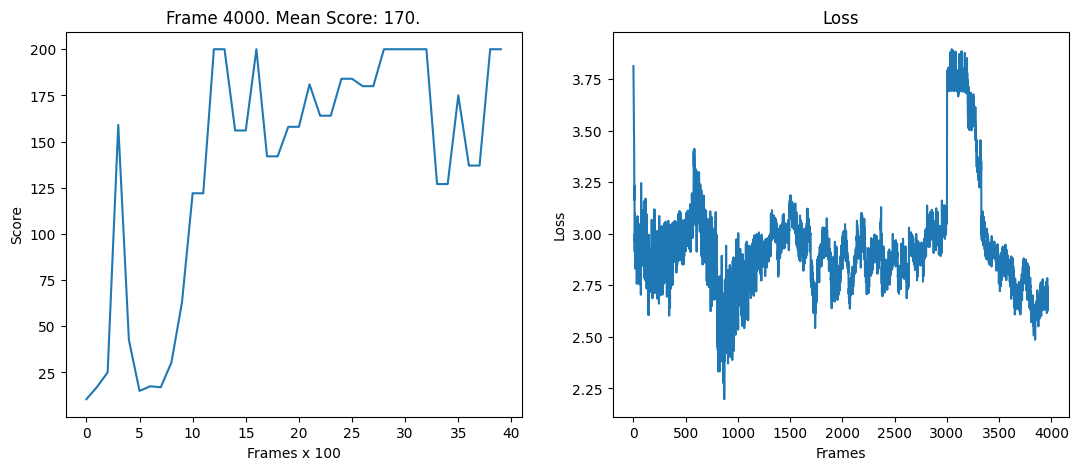

In [ ]:
ap = argparse.ArgumentParser()
ap.add_argument("-nf", "--num_frames", type=int, default=4000,
                help="number of training frames")
ap.add_argument("-plt", "--plot", default=False, action='store_true',
                help="Plot training stats during training for each network")
ap.add_argument("-pi", "--plotting_interval", type=int, default=100,
                help="Number of steps per plots update")
args,unkown= ap.parse_known_args()

# hyper parameters
num_frames = int(args.num_frames)
memory_size = int(args.num_frames / 10)
batch_size = 32
target_update = int(args.num_frames / 10)
plotting_interval = args.plotting_interval
plot = args.plot
# seed
seed = 777
# make environment
env_id = "CartPole-v0"
env = gym.make(env_id)

set_seed(seed, env)

# train
agent_rainbow = DQNAgent(env, memory_size, batch_size, target_update,
                          no_dueling=False, no_categorical=False, no_double=False,
                          no_n_step=False, no_noise=False, no_priority=False,
                          plot=plot, frame_interval=plotting_interval)
DQN_ = DQNAgent(env, memory_size, batch_size, target_update,
                            no_dueling=True, no_categorical=True, no_double=False,
                            no_n_step=True, no_noise=True, no_priority=True,
                            plot=plot, frame_interval=plotting_interval)
DQN_no_noise = DQNAgent(env, memory_size, batch_size, target_update,
                            no_dueling=False, no_categorical=False, no_double=False,
                            no_n_step=False, no_noise=True, no_priority=False,
                            plot=plot, frame_interval=plotting_interval)
DQN_no_mstep = DQNAgent(env, memory_size, batch_size, target_update,
                            no_dueling=False, no_categorical=False, no_double=False,
                            no_n_step=True, no_noise=False, no_priority=False,
                            plot=plot, frame_interval=plotting_interval)
DQN_no_dueling = DQNAgent(env, memory_size, batch_size, target_update,
                            no_dueling=True, no_categorical=False, no_double=False,
                            no_n_step=False, no_noise=False, no_priority=False,
                            plot=plot, frame_interval=plotting_interval)

DQN_no_priorty = DQNAgent(env, memory_size, batch_size, target_update,
                            no_dueling=False, no_categorical=False, no_double=False,
                            no_n_step=False, no_noise=False, no_priority=True,
                            plot=plot, frame_interval=plotting_interval)
DQN_no_double = DQNAgent(env, memory_size, batch_size, target_update,
                            no_dueling=False, no_categorical=False, no_double=True,
                            no_n_step=False, no_noise=False, no_priority=False,
                            plot=plot, frame_interval=plotting_interval)








agents = [agent_rainbow, DQN_,DQN_no_noise,DQN_no_mstep,DQN_no_dueling,DQN_no_priorty,DQN_no_double]
labels = ["Rainbow", "DQN","No_noisy","no_n_step","no_dueling","no_priority","no_double"]
scores = []
losses = []
for i, agent in enumerate(agents):
    print("Training agent", labels[i])
    score, loss = agent.train(num_frames)
    scores.append(score)
    losses.append(loss)
agent_rainbow._plot(num_frames,scores[0],losses[0])


# Comparison of Rainbow Agent

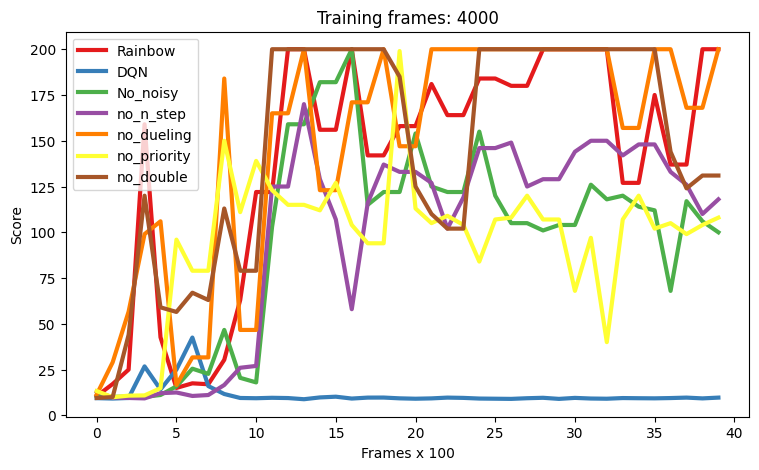

In [ ]:
# create a color palette
palette = plt.get_cmap('Set1')
plt.figure(figsize=(30, 5))
plt.subplot(131)
plt.title('Training frames: %s' % num_frames) #
for i in range(len(scores)):
    linewidth = 3.
    plt.plot(scores[i], marker='', color=palette(i), linewidth=linewidth, alpha=1., label=labels[i])
plt.legend(loc=2, ncol=1)
plt.xlabel("Frames x " + str(plotting_interval))
plt.ylabel("Score")
plt.show() #

In [ ]:
ap = argparse.ArgumentParser()
ap.add_argument("-nf", "--num_frames", type=int, default=10000,
                help="number of training frames")
ap.add_argument("-plt", "--plot", default=False, action='store_true',
                help="Plot training stats during training for each network")
ap.add_argument("-pi", "--plotting_interval", type=int, default=100,
                help="Number of steps per plots update")
args,unkown= ap.parse_known_args()

# hyper parameters
num_frames = int(args.num_frames)
memory_size = int(args.num_frames / 10)
batch_size = 32
target_update = int(args.num_frames / 10)
plotting_interval = args.plotting_interval
plot = args.plot
# seed
seed = 777
# make environment
env_id = "Pendulum-v1"
env = gym.make(env_id)

set_seed(seed, env)

# train
agent_rainbow = DQNAgent(env, memory_size, batch_size, target_update,
                          no_dueling=False, no_categorical=False, no_double=False,
                          no_n_step=False, no_noise=False, no_priority=False,
                          plot=plot, frame_interval=plotting_interval)
DQN_ = DQNAgent(env, memory_size, batch_size, target_update,
                            no_dueling=True, no_categorical=True, no_double=False,
                            no_n_step=True, no_noise=True, no_priority=True,
                            plot=plot, frame_interval=plotting_interval)
DQN_no_noise = DQNAgent(env, memory_size, batch_size, target_update,
                            no_dueling=False, no_categorical=False, no_double=False,
                            no_n_step=False, no_noise=True, no_priority=False,
                            plot=plot, frame_interval=plotting_interval)
DQN_no_mstep = DQNAgent(env, memory_size, batch_size, target_update,
                            no_dueling=False, no_categorical=False, no_double=False,
                            no_n_step=True, no_noise=False, no_priority=False,
                            plot=plot, frame_interval=plotting_interval)
DQN_no_dueling = DQNAgent(env, memory_size, batch_size, target_update,
                            no_dueling=True, no_categorical=False, no_double=False,
                            no_n_step=False, no_noise=False, no_priority=False,
                            plot=plot, frame_interval=plotting_interval)

DQN_no_priorty = DQNAgent(env, memory_size, batch_size, target_update,
                            no_dueling=False, no_categorical=False, no_double=False,
                            no_n_step=False, no_noise=False, no_priority=True,
                            plot=plot, frame_interval=plotting_interval)
DQN_no_double = DQNAgent(env, memory_size, batch_size, target_update,
                            no_dueling=False, no_categorical=False, no_double=True,
                            no_n_step=False, no_noise=False, no_priority=False,
                            plot=plot, frame_interval=plotting_interval)


agents = [agent_rainbow, DQN_,DQN_no_noise,DQN_no_mstep,DQN_no_dueling,DQN_no_priorty,DQN_no_double]
labels = ["Rainbow", "DQN","No_noisy","no_n_step","no_dueling","no_priority","no_double"]
scores = []
losses = []
for i, agent in enumerate(agents):
    print("Training agent", labels[i])
    score, loss = agent.train(num_frames)
    scores.append(score)
    losses.append(loss)


Using DenseNet
Device cpu
Using DenseNet
Device cpu
Using DenseNet
Device cpu
Using DenseNet
Device cpu
Using DenseNet
Device cpu
Using DenseNet
Device cpu
Using DenseNet
Device cpu
Training agent Rainbow
Saving model...
Model saved in: models/rainbow.tar
Saving model...
Model saved in: models/rainbow.tar
Saving model...
Model saved in: models/rainbow.tar
Saving model...
Model saved in: models/rainbow.tar
Saving model...
Model saved in: models/rainbow.tar
Saving model...
Model saved in: models/rainbow.tar
Saving model...
Model saved in: models/rainbow.tar
Saving model...
Model saved in: models/rainbow.tar
Saving model...
Model saved in: models/rainbow.tar
Saving model...
Model saved in: models/rainbow.tar
Saving model...
Model saved in: models/rainbow.tar
Saving model...
Model saved in: models/rainbow.tar
Saving model...
Model saved in: models/rainbow.tar
Saving model...
Model saved in: models/rainbow.tar
Saving model...
Model saved in: models/rainbow.tar
Saving model...
Model saved in

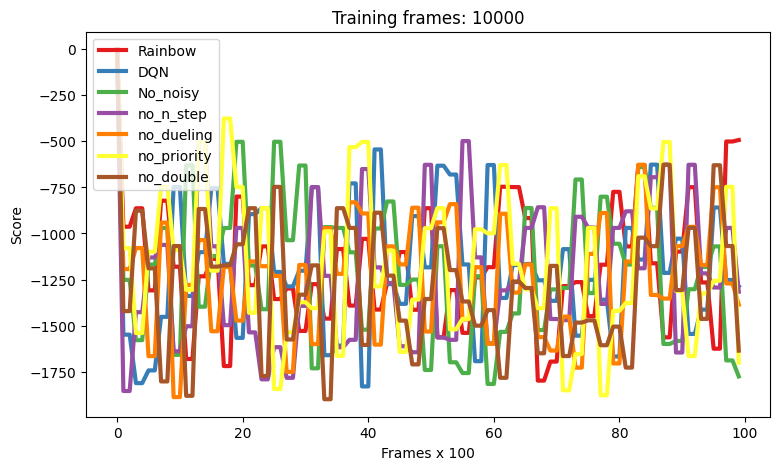

In [ ]:
# create a color palette
palette = plt.get_cmap('Set1')
plt.figure(figsize=(30, 5))
plt.subplot(131)
plt.title('Training frames: %s' % num_frames) #
for i in range(len(scores)):
    linewidth = 3.
    plt.plot(scores[i], marker='', color=palette(i), linewidth=linewidth, alpha=1., label=labels[i])
plt.legend(loc=2, ncol=1)
plt.xlabel("Frames x " + str(plotting_interval))
plt.ylabel("Score")
plt.show() #

In [ ]:
[]